# Example Usage

This is a basic example using the torchvision COCO dataset from coco.py, it assumes that you've already downloaded the COCO images and annotations JSON.  You'll notice that the scale augmentations are quite extreme.

In [1]:
category_ids = {
    "UNKNOWN": 0,
    "General trash": 1,
    "Paper": 2,
    "Paper pack": 3,
    "Metal": 4,
    "Glass": 5,
    "Plastic": 6,
    "Styrofoam": 7,
    "Plastic bag": 8,
    "Battery": 9,
    "Clothing": 10
}

category_colors = {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "10": 10
}

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import cv2
import numpy as np
from copy_paste import CopyPaste
from coco import CocoDetectionCP
from visualize import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt

In [31]:
# dataset에 copypaste 적용
transform = A.Compose([
        CopyPaste(blend=True, sigma=1, pct_objects_paste=1, p=1.) #pct_objects_paste is a guess
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

data = CocoDetectionCP(
    '/opt/ml/input/data', 
    '/opt/ml/input/data/train.json', 
    transform
)

loading annotations into memory...
Done (t=4.83s)
creating index...
index created!


In [6]:
# train.json 파일 로드 
import pandas as pd
import json
with open('/opt/ml/input/data/train.json',encoding='utf-8') as f:
    train_json=json.load(f)

In [121]:
# 각 정보? 를 가가각 dataframe으로 저장
info_df=pd.json_normalize(train_json['info'])
li_df=pd.json_normalize(train_json['licenses'])
images_df=pd.json_normalize(train_json['images'])
cates_df=pd.json_normalize(train_json['categories'])
anns_df=pd.json_normalize(train_json['annotations'])

In [124]:

anns_df.tail(10)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
21107,21107,2615,2,"[[304, 358, 303, 358, 302, 358, 301, 358, 300,...",42176.0,"[104.4, 146.4, 236.7, 212.5]",0
21108,21108,2615,2,"[[29, 424, 28, 424, 27, 424, 26, 424, 25, 424,...",1110.5,"[0.0, 400.4, 64.2, 24.1]",0
21109,21109,2615,2,"[[20, 199, 19, 199, 19, 198, 19, 197, 19, 196,...",637.5,"[18.9, 128.2, 27.1, 73.6]",0
21110,21110,2615,2,"[[0, 248, 0, 248, 0, 247, 0, 246, 0, 245, 0, 2...",2078.0,"[0.0, 81.0, 35.4, 167.6]",0
21111,21111,2615,2,"[[0, 180, 0, 180, 0, 179, 0, 178, 0, 177, 0, 1...",1451.5,"[0.0, 97.2, 28.9, 82.9]",0
21112,21112,2615,2,"[[0, 175, 0, 175, 0, 174, 0, 173, 0, 172, 0, 1...",212.5,"[0.0, 151.4, 17.7, 24.1]",0
21113,21113,2615,2,"[[5, 408, 4, 408, 3, 408, 2, 408, 1, 408, 0, 4...",14152.5,"[0.0, 261.0, 112.8, 147.7]",0
21114,21114,2615,2,"[[7, 511, 6, 511, 5, 511, 4, 511, 3, 511, 2, 5...",1044.0,"[0.3, 426.3, 16.7, 85.6]",0
21115,21115,2616,4,"[[314, 430, 313, 430, 312, 430, 311, 430, 310,...",27000.0,"[258.7, 158.3, 124.9, 272.0]",0
21116,21116,2617,6,"[[414, 107, 413, 108, 413, 110, 412, 111, 412,...",35120.0,"(128, 107, 381, 348)",0


1
6
35120.0


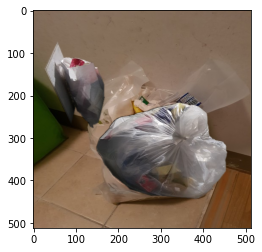

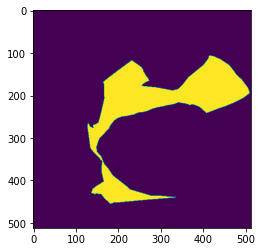

In [123]:
# import json
from copy import deepcopy
main_json={}
img_id=2616  # train.json img_id 마지막 값
ann_id=21115 # train.json anns_id 마지막 값
for i in range(len(data)): 
    img_id+=1   # 새이미지가 들어오니 ++
    img_data = deepcopy(data[i])  # 일단 copy
    # img_data는 dict type으로 다음과 같은 key를 가지고 있음 ['image','info 'masks', 'bboxes', 'paste_image', 'paste_masks', 'paste_bboxes', 'paste_index']
    # image : 사진 (512 *512)
    # info : 이미지 메타정보
    # masks : copy & paste가 적용된 masks -> 각 mask 마다 512*512로 구성되어 있음
    # boxes : 박스의 개수 x,y,w,h,클래스_index, 한 이밎에서 몇번쨰 index
    image_info = img_data['info'] # 이미지 정보 load
    image_info[0]['file_name']=image_info[0]['file_name'][:-4]+'cp.jpg'  # 기존 파일명에 cp를 붙임 ex) batch/003.jpg -> batch/003cp.jpg
    image_info[0]['id']=img_id # img_id값 변경
    # print(image_info)
    images_df.loc[img_id]=image_info[0] #df 끝에 append
    bboxes = img_data['bboxes'] # box 정보들을 load (일단 사용 안함) -> conotour 개수랑 안맞아서 ㅠㅠ
    for mask in img_data['masks']:
        contours , _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # contour
        # annotatiopn 정보 작성
        temp_ann={
            'id':None,
            'image_id':img_id,
            'category_id':box[4],
            'segmentation':None,
            'area':None,
            'bbox':None,
            'iscrowd':0,
        }
        # print(len(contours))
        # print(len(box))
        for contour in contours:
            temp_area=cv2.contourArea(contour)
            print(temp_area)
            if temp_area>1000: # contour area가 1000보다 크면 
                ann_id+=1 #
                # bbox 만들기
                bbox = cv2.boundingRect(contour)
                # 정보 입력후 annotation df에 추가
                temp_ann['id']=ann_id
                temp_ann['segmentation']=[list(contour.flatten())]
                temp_ann['area']=temp_area
                temp_ann['bbox']=bbox
                anns_df.loc[ann_id]=temp_ann
            # break
        plt.imshow(img_data['image'])
        plt.figure()
        plt.imshow(mask)
        break
    break

In [100]:
bboxes

[(138.0, 118.0, 371.0, 337.0, 8, 0),
 (374.0, 241.0, 1.0, 1.0, 8, 2),
 (249.0, 203.0, 1.0, 1.0, 1, 3),
 (263.0, 220.0, 26.0, 12.0, 1, 8),
 (273.0, 223.0, 1.0, 1.0, 1, 9),
 (265.0, 221.0, 1.0, 1.0, 8, 10),
 (167.0, 260.0, 14.0, 5.0, 8, 11),
 (201.0, 212.0, 33.0, 40.0, 1, 12),
 (0.0, 180.0, 70.0, 182.0, 1, 13),
 (215.0, 182.0, 274.0, 98.0, 8, 14),
 (31.0, 252.0, 204.0, 194.0, 8, 15),
 (467.0, 242.0, 44.0, 92.0, 8, 16),
 (165.0, 167.0, 65.0, 73.0, 8, 17),
 (192.0, 94.0, 286.0, 149.0, 8, 18),
 (67.0, 198.0, 160.0, 98.0, 8, 19)]

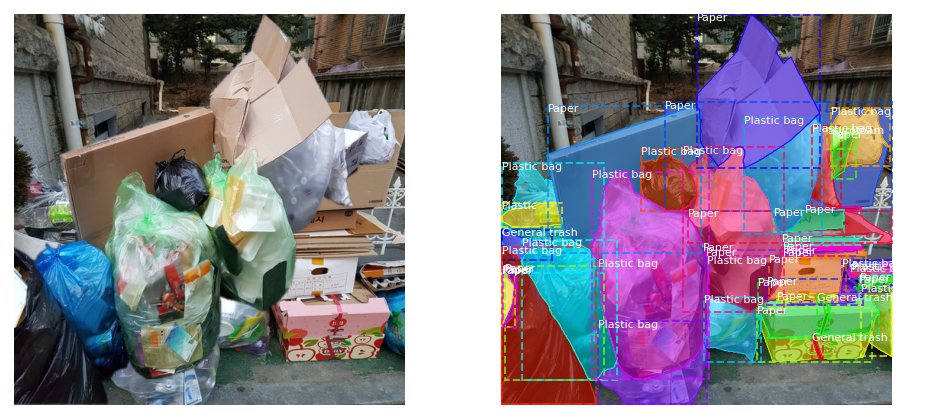

In [77]:
f, ax = plt.subplots(1, 2, figsize=(16, 16))

index = random.randint(0, len(data))
img_data = data[index]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']

empty = np.array([])
display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0])

if len(bboxes) > 0:
    boxes = np.stack([b[:4] for b in bboxes], axis=0)
    box_classes = np.array([b[-2] for b in bboxes])
    mask_indices = np.array([b[-1] for b in bboxes])
    show_masks = np.stack(masks, axis=-1)[..., mask_indices]
    class_names = {k: data.coco.cats[k]['name'] for k in data.coco.cats.keys()}
    display_instances(image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1])
else:
    display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1])

In [13]:
for i in data:
    # print(i['image'])
    print(i['masks'][1].shape)    
    classMap = np.argmax(i['masks'][1], axis=0)
    print(classMap.shape)
    print(i.keys())
    break

(512, 512)
(512,)
dict_keys(['image', 'masks', 'bboxes', 'paste_image', 'paste_masks', 'paste_bboxes', 'paste_index'])


In [44]:
i['bboxes']

[(137.0, 107.0, 372.0, 348.0, 8, 0),
 (336.0, 193.0, 60.0, 43.0, 8, 1),
 (363.0, 234.0, 23.0, 15.0, 8, 2),
 (333.0, 192.0, 13.0, 17.0, 1, 6),
 (0.0, 180.0, 84.0, 182.0, 1, 13),
 (79.0, 100.0, 263.0, 295.0, 6, 14),
 (304.0, 155.0, 98.0, 110.0, 1, 15)]

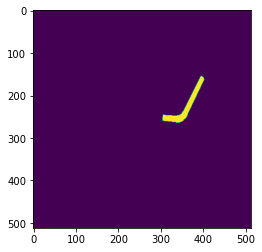

In [24]:
plt.imshow(i['masks'][15])

In [31]:
len(i['masks'][15][i['masks'][15]==0])

260123

In [32]:
len(i['masks'][15][i['masks'][15]==1])

2021

In [47]:
contours , _ = cv2.findContours(i['masks'][15], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour = contours[0]

# contour[:,:,0] 은 point의 x좌표 값만 포함하는 배열
# contour[:,:,1] 은 point의 y좌표 값만 포함하는 배열

TypeError: 'int' object is not subscriptable

In [46]:
contour

NameError: name 'contour' is not defined

In [37]:
cnt=0

for aaaa in data:
    for bbbb in aaaa['masks']:
        contours , _ = cv2.findContours(bbbb, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours)!=1:
            cnt+=1
print(cnt)

15650


In [39]:
def get_coco_json_format():
    # Standard COCO format 
    coco_format = {
        "info": {
            "year": 2021,
            "version": "1.0",
            "description": "Recycle Trash",
            "contributor": "Upstage",
            "url": None,
            "date_created": "2021-02-02 01:10:00"
        },
        "licenses": [{
            "id": 0,
            "name": "CC BY 4.0",
            "url": "https://creativecommons.org/licenses/by/4.0/deed.ast"
        }],
        "images": [],
        "categories": [],
        "annotations": []
    }

    return coco_format